In [29]:
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import scipy
from scipy.io.wavfile import write
from scipy.fft import fft, fftfreq
import itertools
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
# Матрица ошибок классификатора
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import gdown
from scipy.fft import fft, fftfreq
from scipy.fft import rfft, rfftfreq
#warnings.filterwarnings('ignore')
sns.set_style('darkgrid')
import random

In [2]:
import warnings
warnings.filterwarnings('ignore')
# Классы-конструкторы моделей нейронных сетей
from tensorflow.keras.models import Sequential, Model,  Sequential, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import concatenate, Input, multiply, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, LSTM, GlobalMaxPooling1D, MaxPooling1D, RepeatVector
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adadelta, Adagrad, Adamax, Nadam, Ftrl
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder

1. Перекрытие 50 на 50
2. Делим выборку на 2 и сверяем их
3. Размечаем одинаковые-разные
4. Пока фиксированная ширина окна
5. Модель принимает вектор пока что, но какие варианты? 2 канала, скрытое состояние либо автокодировщик

1. Функция, которая генерирует сигналы с заданным перекрытием
2. Функция которая раскидывает по спектрам с окном

In [114]:
def make_2_signals(window = 3000, mean1 = 3, mean2 = 5, overlap = 0.5):
    """
    Функция принимает размер будущего сигнала, параметры усреднения стыка сигналов, перекрытие, и частоту дискретизации
    :param window:
    :param mean1:
    :param mean2:
    :param overlap:
    :param SAMPLE_RATE:
    :return: signal + label
    """
    duration = window * 2  # Секунды
    if overlap == 0:
        x1 = np.random.normal(0,1,duration)
        x1 = pd.Series(x1).rolling(window = mean1).mean().dropna()
        x1 = x1/(np.abs(x1).max())
        return x1[:window], 0
    else:
        x1 = np.random.normal(0,1,duration) # Первый сигнал
        x2 = np.random.normal(0,1,duration) # Второй сигнал

        # Усреднение, обрезание, нормировка, склейка
        x1 = pd.Series(x1).rolling(window = mean1).mean().dropna().values
        x2 = pd.Series(x2).rolling(window = mean2).mean().dropna().values
        x1 = x1/(np.abs(x1).max())
        x2 = x2/(np.abs(x2).max())
        len_1 = int(window * (1 - overlap))
        len_2 = window - len_1
        x = np.concatenate((x1[:len_1],x2[:len_2]))
        return x, 1

In [54]:
def make_data(WINDOW = 3000, N_signals = 1000, overlap = 0.5, SAMPLE_RATE = 1000):
    mean1 = random.randint(2,5)
    mean2 = random.randint(2,5)
    while mean1 == mean2:
        mean2 = random.randint(2,5)

    diffrent_signals = [ make_2_signals(window = WINDOW, mean1 = mean1, mean2 = mean2, overlap = overlap, SAMPLE_RATE = SAMPLE_RATE) for i in range(int(N_signals/2))]
    y1 = [1]*len(diffrent_signals)
    one_signal = [ make_2_signals(window = WINDOW, mean1 = mean1, mean2 = mean2, overlap = 0, SAMPLE_RATE = SAMPLE_RATE) for i in range(int(N_signals/2))]
    y2 = [0]*len(one_signal)
    signals = np.array(diffrent_signals + one_signal)
    signal_1 = np.array([i[:int(WINDOW/2)] for i in signals])
    signal_2 = np.array([i[(WINDOW - int(WINDOW/2)):] for i in signals])
    signal_1_fft = np.array([np.abs(rfft(i.flatten())) for i in signal_1])
    signal_1_fft = np.array([i/i.max() for i in signal_1_fft])
    signal_2_fft = np.array([np.abs(rfft(i.flatten())) for i in signal_2])
    signal_2_fft = np.array([i/i.max() for i in signal_2_fft])
    y = to_categorical(np.array(y1 + y2))
    print('Размеры сигналов', signals.shape, signal_1.shape, signal_2.shape)
    print('Размеры спектров', signal_1_fft.shape, signal_2_fft.shape)
    print('Размеры классов', y.shape)
    return signal_1_fft, signal_2_fft, y

In [67]:
signal_1_fft, signal_2_fft, y = make_data(WINDOW = 3000, N_signals = 10000, overlap = 0.3, SAMPLE_RATE = 1000)

Размеры сигналов (10000, 3000) (10000, 1500) (10000, 1500)
Размеры спектров (10000, 751) (10000, 751)
Размеры классов (10000, 2)


In [101]:
X = np.concatenate([signal_1_fft, signal_2_fft], axis=1)
print(signal_1_fft.shape)
print(signal_2_fft.shape)
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size=0.3)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(10000, 751)
(10000, 751)
(7000, 1502)
(7000, 2)
(3000, 1502)
(3000, 2)


In [109]:
input1 = Input(X_train.shape[1])
l = Dense(10, activation="relu")(input1)
l = Dropout(0.25)(l)
#l = BatchNormalization()(l)
l = Dense(2, activation = 'softmax')(l)
model = Model(input1, l)

In [110]:
# Компиляция модели
model.compile(optimizer=Adam(lr=1e-3),
            loss='categorical_crossentropy',
            metrics=['accuracy'])
model.summary()

Model: "model_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_18 (InputLayer)       [(None, 1502)]            0         
                                                                 
 dense_34 (Dense)            (None, 10)                15030     
                                                                 
 dropout_17 (Dropout)        (None, 10)                0         
                                                                 
 dense_35 (Dense)            (None, 2)                 22        
                                                                 
Total params: 15,052
Trainable params: 15,052
Non-trainable params: 0
_________________________________________________________________


In [111]:
EPOCHS = 15
# Обучение модели
history = model.fit(X_train,
                    y_train,
                    epochs=EPOCHS,
                    batch_size=16,
                    validation_data=(X_test, y_test),
                    verbose = 1)

Epoch 1/15
438/438 [==============================] - 1s 2ms/step - loss: 0.1885 - accuracy: 0.9466 - val_loss: 0.0253 - val_accuracy: 1.0000
Epoch 2/15
438/438 [==============================] - 1s 2ms/step - loss: 0.0638 - accuracy: 0.9963 - val_loss: 0.0060 - val_accuracy: 1.0000
Epoch 3/15
438/438 [==============================] - 1s 2ms/step - loss: 0.0440 - accuracy: 0.9977 - val_loss: 0.0031 - val_accuracy: 1.0000
Epoch 4/15
438/438 [==============================] - 1s 2ms/step - loss: 0.0296 - accuracy: 0.9983 - val_loss: 0.0020 - val_accuracy: 1.0000
Epoch 5/15
438/438 [==============================] - 1s 2ms/step - loss: 0.0247 - accuracy: 0.9977 - val_loss: 8.8000e-04 - val_accuracy: 1.0000
Epoch 6/15
438/438 [==============================] - 1s 2ms/step - loss: 0.0178 - accuracy: 0.9987 - val_loss: 5.8288e-04 - val_accuracy: 1.0000
Epoch 7/15
438/438 [==============================] - 1s 2ms/step - loss: 0.0165 - accuracy: 0.9980 - val_loss: 2.9477e-04 - val_accuracy: 1

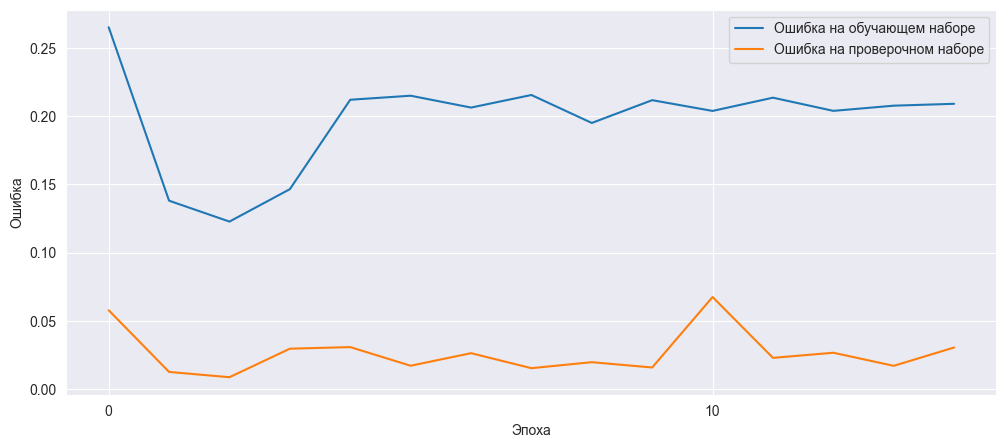

In [87]:
# Вывод графика точности распознавания на обучающей и проверочной выборках
plt.figure(figsize=(12, 5))
plt.plot(history.history['loss'], label='Ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], label='Ошибка на проверочном наборе')
plt.xticks(range(0, EPOCHS, 10))
plt.xlabel('Эпоха')
plt.ylabel('Ошибка')
plt.legend()
plt.show()

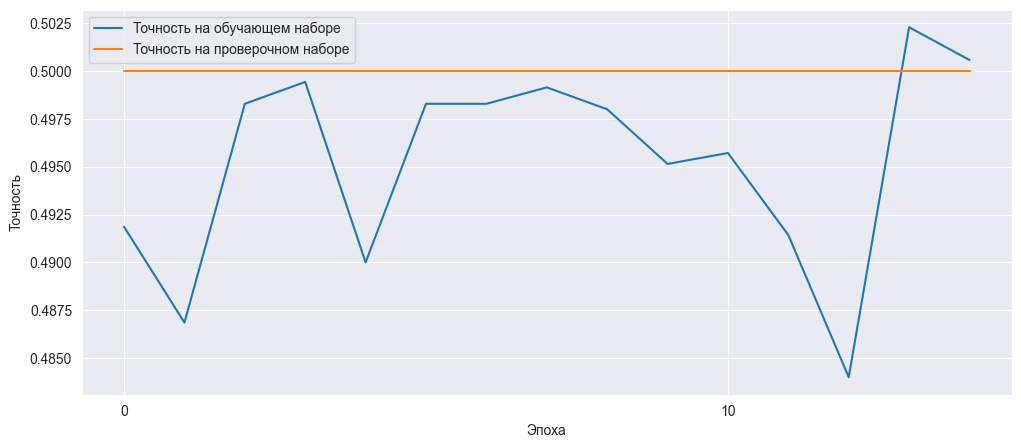

In [105]:
# Вывод графика точности распознавания на обучающей и проверочной выборках
plt.figure(figsize=(12, 5))
plt.plot(history.history['accuracy'], label='Точность на обучающем наборе')
plt.plot(history.history['val_accuracy'], label='Точность на проверочном наборе')
plt.xticks(range(0, EPOCHS, 10))
plt.xlabel('Эпоха')
plt.ylabel('Точность')
plt.legend()
plt.show()


In [112]:
y_pred = np.argmax(model.predict(X_test), axis=1)
print(classification_report(np.argmax(y_test, axis=1), y_pred))

94/94 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1500
           1       1.00      1.00      1.00      1500

    accuracy                           1.00      3000
   macro avg       1.00      1.00      1.00      3000
weighted avg       1.00      1.00      1.00      3000



In [113]:
model.predict(X_test)

94/94 [==============================] - 0s 1ms/step


array([[1.6213099e-02, 9.8378688e-01],
       [1.0000000e+00, 2.4068465e-14],
       [1.6213099e-02, 9.8378688e-01],
       ...,
       [1.6213099e-02, 9.8378688e-01],
       [1.0000000e+00, 1.8638420e-09],
       [1.6213099e-02, 9.8378688e-01]], dtype=float32)

In [74]:
y_pred = np.argmax(model.predict(X_train), axis=1)
print(classification_report(np.argmax(y_train, axis=1), y_pred))

219/219 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3500
           1       1.00      1.00      1.00      3500

    accuracy                           1.00      7000
   macro avg       1.00      1.00      1.00      7000
weighted avg       1.00      1.00      1.00      7000

